In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.stats import gamma, halfnorm
from tqdm import tqdm
import corner
import emcee
from emcee.moves import WalkMove,DEMove
from scipy.stats import uniform

In [2]:
x = np.array([0.04330127006913202,	
0.04999999999981704	
,0.05873678649902327	
,0.07500000037654297	
,0.09058666578581276	
,0.09914450489134946	
,0.11646857028453979	
,0.12990381056731237	
,0.14871691421859828	
,0.15867073038481103	
,0.18262842855923792	
,0.19833833607688725	
,0.22500000000006706	
,0.24748737341553034	
,0.2739426430539203
,0.29743345953905714	
,0.3233578363783551		
,0.3535533906864989	
,0.39657794465537494	
,0.4461501516094344	])
x.shape

(20,)

In [3]:
y = np.array([
-3.2146335541767
,-3.0602709391830
,-2.6509545283382
,-2.9492265921745
,-3.0200801823019
,-2.9411713554349
,-2.5763799817693
,-2.6946482827198
,-2.6368506172384
,-2.5997375497890
,-2.5386880548195
,-2.5554153237870
,-2.2042359990242
,-2.5509059870583
,-2.18554209191491
,-2.5087712715312
,-2.30149412707814
,-2.06315817953411
,-1.9774563917098
,-2.05421840513918
])
y.shape

(20,)

In [4]:
errory = np.array([0.388486470951241	
,0.3071857349321623	
,0.2423094200928193	
,0.31611288952165095	
,0.453150405666618	
,0.23465308110818706	
,0.294583703960543
,0.15428402950755293	
,0.31391653188986623	
,0.32015214291506044	
,0.42569821558288057	
,0.20276712434154254	
,0.2750805003236527	
,0.28325194395516773	
,0.3061740109613511	
,0.19633369858334992	
,0.2550522222270657	
,0.13260762482205846	
,0.21472741090716863	
,0.20817854715046846	
])
errory.shape

(20,)

<ErrorbarContainer object of 3 artists>

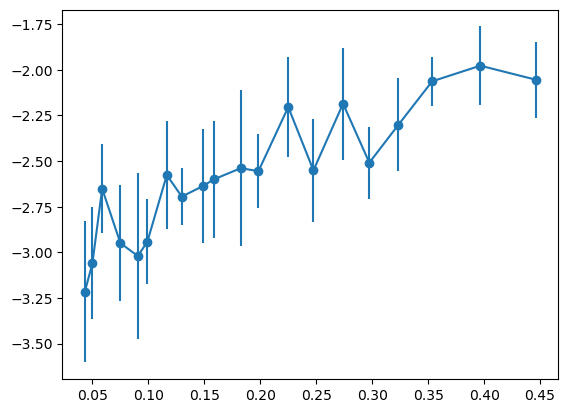

In [5]:
plt.scatter(x,y)
plt.errorbar(x,y,yerr = errory)

In [6]:
xtrain, xtest, ytrain, ytest,etrain,etest = train_test_split(x, y,errory, test_size=0.2,shuffle = True,random_state = 25,)
xtrain = xtrain.reshape(-1,1)
xtest = xtest.reshape(-1,1)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)

### White Kernel. Guess init noise

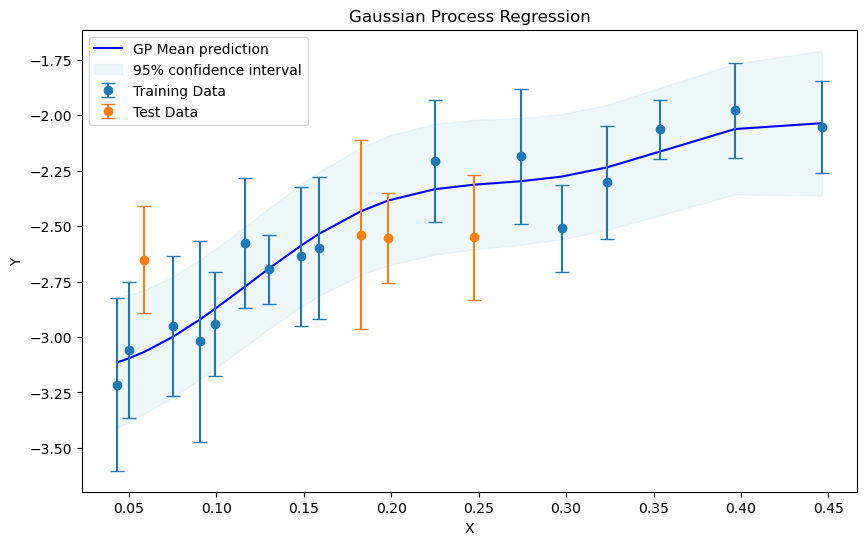

[1.15964952 0.10852427 0.10499667]


In [7]:
boundsl = ((1e-4, 10))  
initl = 1
initvar = 1.0
varbounds = (1e-20,10)
noiselvl = 1
noiselvlbounds = (1e-20,10)

kernel = C(constant_value = initvar,constant_value_bounds = varbounds)* RBF(length_scale= initl, length_scale_bounds= boundsl) + WhiteKernel(noiselvl,noise_level_bounds=noiselvlbounds)
gpr1 = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=10)
gpr1.fit(xtrain, ytrain)
y_pred, sigma = gpr1.predict(x.reshape(-1,1), return_std=True)
# Plot the results
plt.figure(figsize=(10, 6))
#plt.scatter(xtrain, ytrain, c='r', label="Training points")
#plt.scatter(xtest,ytest,label = 'Test points' )
plt.plot(x, y_pred, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
print(np.exp(gpr1.kernel_.theta))

In [8]:
K_train = gpr1.kernel_(xtrain)
#print("Training Covariance Matrix (K(X, X)):\n", K_train)
#print(K_train)
#K_test_train = gpr1.kernel_(xtest, xtrain)
#print("Covariance Matrix (K(X*, X)):\n", K_test_train)
#print(K_test_train)


## White Kernel with initial white noise and bounds set by error bars

c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.17623528547002035. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


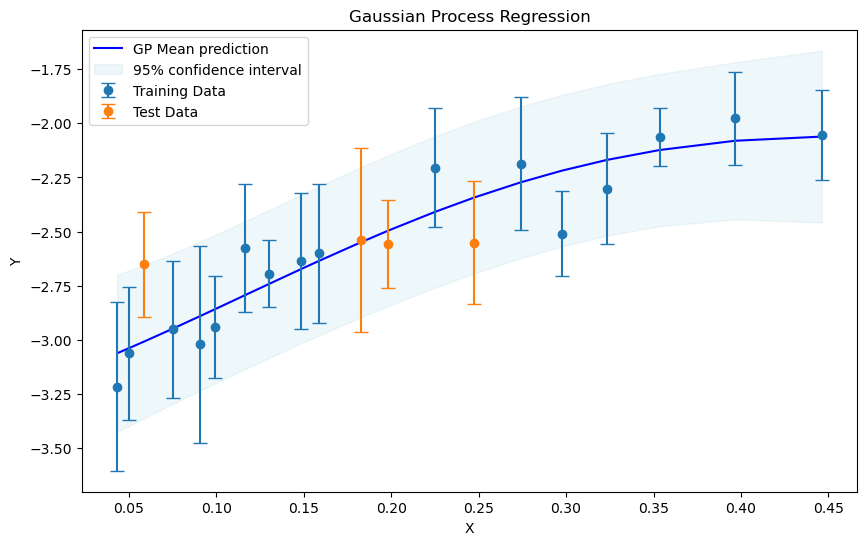

[1.15964952 0.10852427 0.10499667]


In [9]:
boundsl = ((1e-4, 10))  
initl = 1
initvar = 1.0
varbounds = (1e-20, 1e20)
noiselvl = errory.mean()
noiselvlbounds = (errory.mean()-1e-1,errory.mean()+1e-1)

kernel = C(constant_value = initvar,constant_value_bounds = varbounds)* RBF(length_scale= initl, length_scale_bounds= boundsl)+WhiteKernel(noiselvl,noise_level_bounds=noiselvlbounds)
gpr2 = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=10)
gpr2.fit(xtrain, ytrain)
y_pred, sigma = gpr2.predict(x.reshape(-1,1), return_std=True)
# Plot the results
plt.figure(figsize=(10, 6))
#plt.scatter(xtrain, ytrain, c='r', label="Training points")
#plt.scatter(xtest,ytest,label = 'Test points' )
plt.plot(x, y_pred, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
print(np.exp(gpr1.kernel_.theta))

## Using alpha = Err^2, pointwise known noise

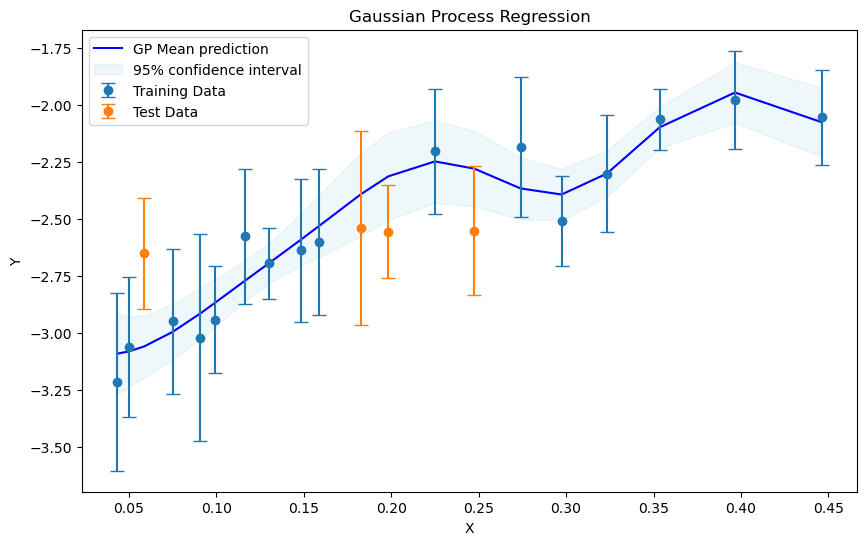

In [10]:
##### Note output changes massively with l bounds
boundsl = ((0.0001, 10))  
initl = 1
initvar = 1.0
varbounds = (0.0001, 1e20)


kernel = C(constant_value = initvar,constant_value_bounds = varbounds)* RBF(length_scale= initl, length_scale_bounds= boundsl)
gpr3 = GaussianProcessRegressor(kernel=kernel,alpha = etrain**2,normalize_y=True, n_restarts_optimizer=10)
gpr3.fit(xtrain, ytrain)
y_pred, sigma = gpr3.predict(x.reshape(-1,1), return_std=True)
# Plot the results
plt.figure(figsize=(10, 6))
#plt.scatter(xtrain, ytrain, c='r', label="Training points")
#plt.scatter(xtest,ytest,label = 'Test points' )
plt.plot(x, y_pred, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
sigma = np.exp(gpr3.kernel_.theta)[0]
l = np.exp(gpr3.kernel_.theta)[1]
#### New value min(l/etrain) , I have found this to help me not overfight or underfit if I keep it in regions of 0.1 to 0.5. How could I add this to my model above???

In [11]:
print(l)
print(sigma)

0.06354375113719671
0.9061208021714976


In [12]:
K_train = gpr3.kernel_(xtrain)
#print("Training Covariance Matrix (K(X, X)):\n", K_train)
print(np.diag(K_train))
#K_test_train = gpr1.kernel_(xtest, xtrain)
#print("Covariance Matrix (K(X*, X)):\n", K_test_train)
#print(K_test_train)

[0.9061208 0.9061208 0.9061208 0.9061208 0.9061208 0.9061208 0.9061208
 0.9061208 0.9061208 0.9061208 0.9061208 0.9061208 0.9061208 0.9061208
 0.9061208 0.9061208]


## Monte Carlo sampling with error distributed N(0,err^2)

In [13]:
plt.figure()
n_samples = 200  # Number of Monte Carlo samples
n_gp_samples = 100  # Number of function samples per GP

#C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
kernel = RBF(length_scale=1)



posterior_history = []  
for sample in tqdm(range(n_samples), desc="Monte Carlo Sampling Progress"):

    ####  This follows the logic since we are saying the error is normally distributed with error 0 and std E_train. There for the error bars which represent 1 standard deviation 
    ###### had this as np.random.normal(0, E_train) for ages should be E_train**2 I think
    #### random normal wants std not variance
    sampled = ytrain + np.random.normal(0, etrain.reshape(-1,1))

    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer = 15)
    gpr.fit(xtrain, sampled)

    posterior_sample = gpr.sample_y(x.reshape(-1,1), n_gp_samples)
    #print(posterior_sample.shape)
    #print(posterior_sample)
    #print(posterior_sample.shape)# Expected shape: (250, 10)
    posterior_history.append(posterior_sample)  # Append directly

# Convert to NumPy array for final processing
posterior_history = np.array(posterior_history)

Monte Carlo Sampling Progress:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Monte Carlo Sampling Progress:   2%|▎         | 5/200 [00:00<00:04, 39.43it/s]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit 

<Figure size 640x480 with 0 Axes>

In [14]:
print(posterior_history.shape)

(200, 20, 100)


(20,)


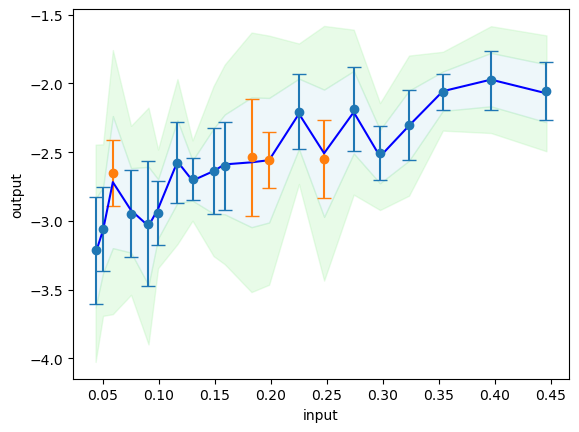

In [15]:
posterior_history = np.array(posterior_history)
mean_posterior = np.mean(posterior_history,axis=(0,2))
std_posterior = np.std(posterior_history,axis=(0,2))
print(mean_posterior.shape)

plt.plot(x.ravel(), mean_posterior, c='w')
plt.fill_between(x.ravel(), mean_posterior - 1 * std_posterior, mean_posterior + 1 * std_posterior,
                 color="lightblue", alpha=0.2, label="95% confidence interval")
plt.fill_between(x.ravel(), mean_posterior -  1 * std_posterior, mean_posterior - 2 * std_posterior,
                 color="lightgreen", alpha=0.2,)
plt.fill_between(x.ravel(), mean_posterior +  1 * std_posterior, mean_posterior + 2 * std_posterior,
                 color="lightgreen", alpha=0.2, label="95% confidence interval")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.plot(x, mean_posterior,'b-')
#plt.scatter(x, y, zorder=6, s=30)
#plt.errorbar(x, y, yerr=errory, ls='none', zorder=6)
plt.xlabel('input')
plt.ylabel('output')
#plt.title('Monte Carlo + RBF Gaussian Process. Accurate but expensive.')
plt.show()
plt.show()

### MCMC. Building a distribution over parameters and being able to see regions where l and sigma are good

In [16]:
def log_prior(theta):
    sigma, l1= theta
    logp_sigma = uniform(loc=0.01, scale=4.99).logpdf(sigma)  
    logp_l1 = uniform(loc=0.01, scale=4.99).logpdf(l1)
    return logp_sigma + logp_l1

In [17]:
def log_posterior(theta):
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():   
        return -np.inf
    
    real_theta = np.exp(theta)
    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr3.log_marginal_likelihood(theta)
    if not np.isfinite(ll):    
        return -np.inf

###### Here I set things to minus infinity this means that they will be rejected and so basically removes them

    return lp + ll

In [18]:
ndim = 2
nwalkers = 10 

mean = np.array([sigma, l])


cov_matrix = np.diag([ 3*sigma, 6* l]) 

### Where we start sampling. I take the absolute value here because I want my parameters to be positive
initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers))  

### Sampler
####move = DEMove(gamma=0.5)  this is an option to use moves = move to try and increase the acceptance fraction
### try different moves
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,moves=DEMove())

nsteps = 10000
samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

acceptance_fraction = sampler.acceptance_fraction


burnin = 100 ## Remove 100 at start of every walker
thin = 15 ## take 1 of every 15 samples
print(acceptance_fraction.mean())

100%|██████████| 10000/10000 [02:08<00:00, 77.66it/s]

0.26060000000000005


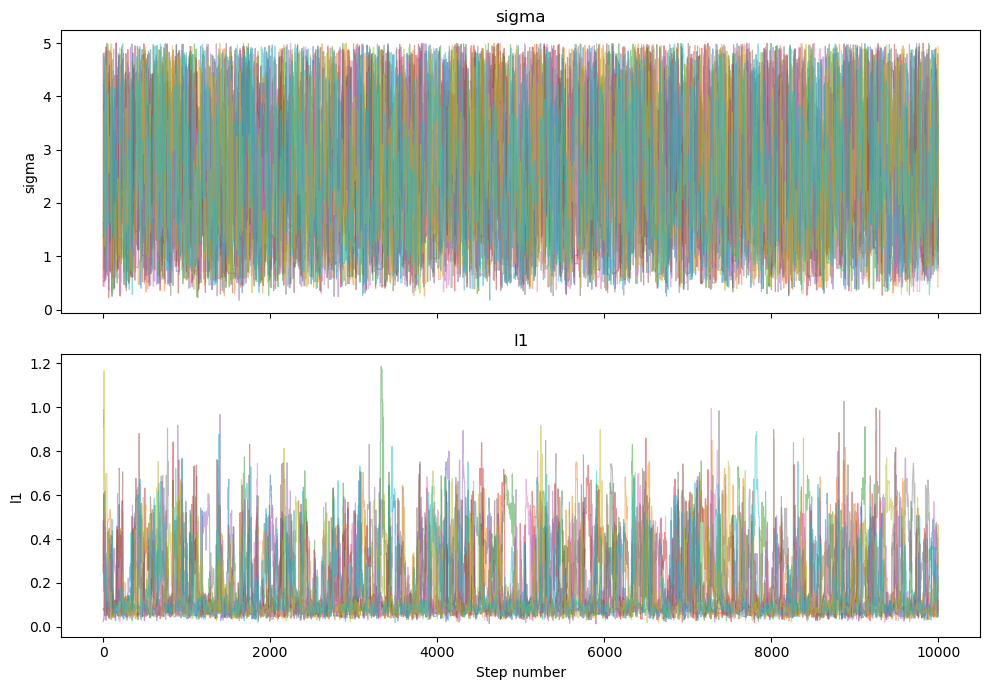

In [19]:
samples1 = sampler.get_chain()

parameter_labels = ["sigma", "l1"]
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    for walker in range(samples1.shape[1]):  
        ax.plot(samples1[:, walker, i], alpha=0.5, lw=0.8)
    ax.set_ylabel(parameter_labels[i])
    ax.set_title(f"{parameter_labels[i]}")

axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

### Finding the kde densities manually so I can pull out the parameter peak values

Peak values for each parameter: [1.1771278858284202, 0.08044572757423654]


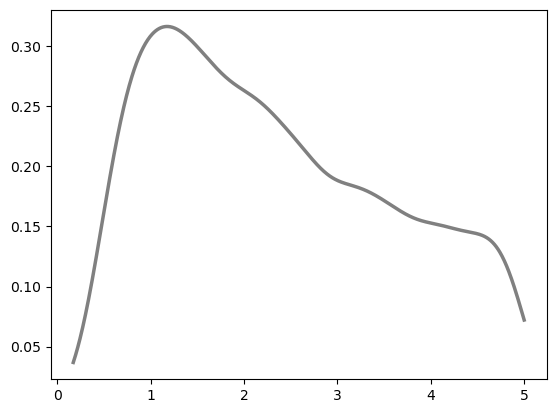

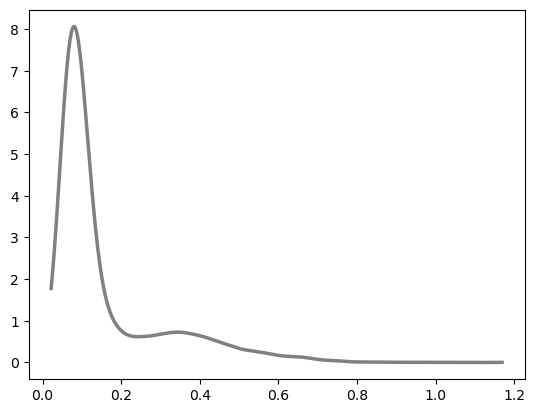

In [22]:
from scipy.stats import gaussian_kde
peak_values = []
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
for i in range(ndim):
    samples_i = flat_samples[:, i]
    kde = gaussian_kde(samples_i)  

    x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
    density = kde(x_range)
    plt.figure()
    plt.plot(x_range, density, 
         color='gray', linewidth=2.5)
    peak = x_range[np.argmax(density)]
    peak_values.append(peak)
print("Peak values for each parameter:", peak_values)

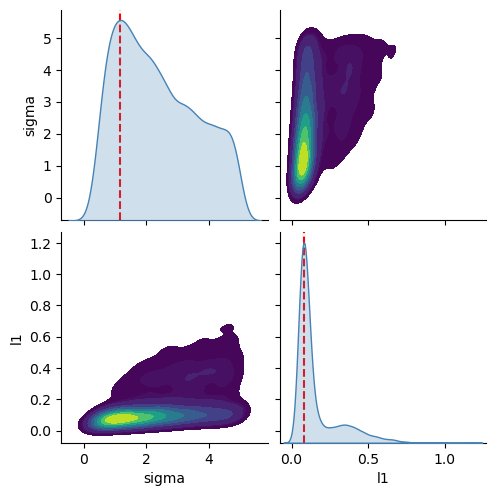

In [23]:
#### Flatten the samples so that I get an array with size (sample number, samples)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
df = pd.DataFrame(flat_samples, columns=["sigma", "l1"])
g = sns.pairplot(
    df,
    kind="kde",
    diag_kind="kde",
    plot_kws={'fill': True, 'cmap': 'viridis'},
    diag_kws={'fill': True, 'color': 'steelblue'},
)

g.axes[0, 0].axvline(peak_values[0], color="red", linestyle="--")   
g.axes[1, 1].axvline(peak_values[1], color="red", linestyle="--")

plt.show()

In [24]:
mean_values = np.mean(flat_samples, axis=0)     
std_values  = np.std(flat_samples, axis=0)       
ci_bounds   = np.percentile(flat_samples, [2.5, 97.5], axis=0)  

labels = ["sigma", "l1"]
for i, label in enumerate(labels):
    # Option 1: Use .item() to extract the scalar
    mean_i = mean_values[i].item()
    std_i  = std_values[i].item()
    lower_ci = ci_bounds[0, i].item()
    upper_ci = ci_bounds[1, i].item()
    print(f"{label}: mean = {mean_i:.4f}, std = {std_i:.4f}, 95% CI = [{lower_ci:.4f}, {upper_ci:.4f}]")

sigma: mean = 2.3622, std = 1.2708, 95% CI = [0.5189, 4.8179]
l1: mean = 0.1575, std = 0.1438, 95% CI = [0.0438, 0.5632]


## Plotting the mean values found by MCMC

In [25]:
sigma = mean_values[0]
l1 = mean_values[1]
print(l1)
print(sigma)

0.15752195667643054
2.362210223924911


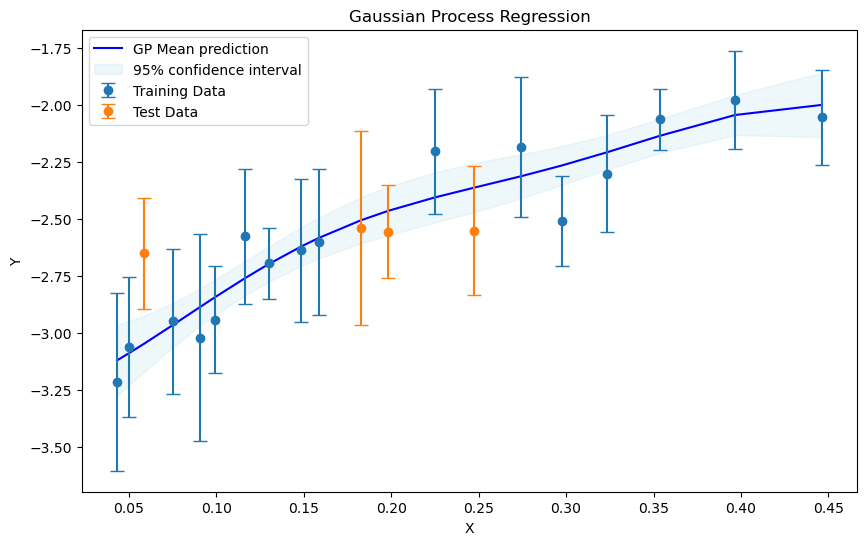

0.15752195667643054


In [26]:
boundsl = ((1e-1, 10))  
initl = l1
initvar = sigma
varbounds = (1e-20, 1e20)
noiselvl = errory.mean()


kernel = C(constant_value = initvar,constant_value_bounds = varbounds)* RBF(length_scale= initl, length_scale_bounds= boundsl)
gpr3 = GaussianProcessRegressor(kernel=kernel,alpha = etrain**2,normalize_y=True, optimizer=None)
gpr3.fit(xtrain, ytrain)
y_pred, sigma = gpr3.predict(x.reshape(-1,1), return_std=True)
# Plot the results
plt.figure(figsize=(10, 6))
#plt.scatter(xtrain, ytrain, c='r', label="Training points")
#plt.scatter(xtest,ytest,label = 'Test points' )
plt.plot(x, y_pred, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
sigma = np.exp(gpr3.kernel_.theta)[0]
l = np.exp(gpr3.kernel_.theta)[1]
print(l)

## Plotting the Peaked values

0.08044572757423654 1.1771278858284202


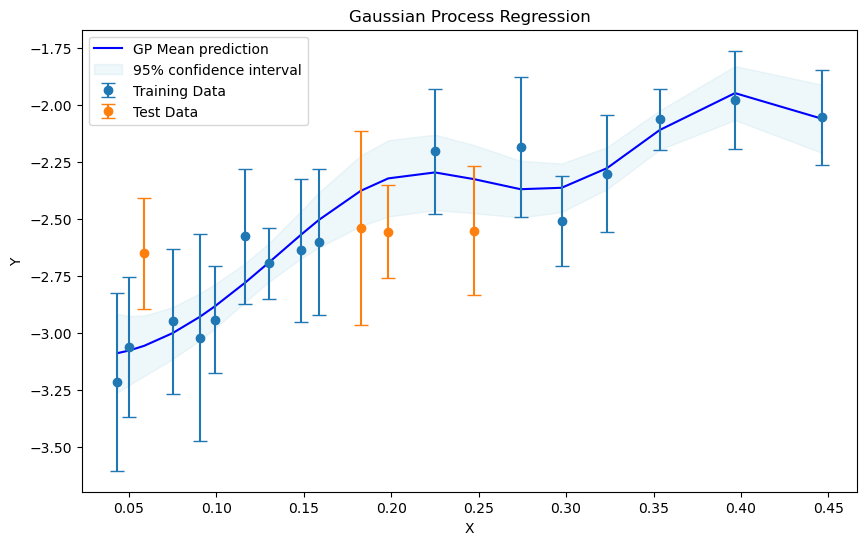

0.08044572757423654


In [29]:
boundsl = ((1e-1, 10))  
initvar = peak_values[0]
initl = peak_values[1]
varbounds = (1e-20, 1e20)
noiselvl = errory.mean()
print(initl,initvar)


kernel = C(constant_value = initvar)* RBF(length_scale= initl)
gpr3 = GaussianProcessRegressor(kernel=kernel,alpha = etrain**2,normalize_y=True, optimizer=None)
gpr3.fit(xtrain, ytrain)
y_pred, sigma = gpr3.predict(x.reshape(-1,1), return_std=True)
# Plot the results
plt.figure(figsize=(10, 6))
#plt.scatter(xtrain, ytrain, c='r', label="Training points")
#plt.scatter(xtest,ytest,label = 'Test points' )
plt.plot(x, y_pred, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
sigma = np.exp(gpr3.kernel_.theta)[0]
l = np.exp(gpr3.kernel_.theta)[1]
print(l)

## Marginalising over Both distributions to find predictive distribution. Sort of cancels out the noise

In [39]:
# Storage for predictions
S = len(flat_samples)
pred_means = np.zeros((S, len(x)))
pred_vars = np.zeros((S, len(x)))

for s in tqdm(range(S), desc="Running GP Predictions", unit="sample"):
    theta_s = flat_samples[s] 
    kernel = gpr3.kernel_.clone_with_theta(theta_s) 
    gp = GaussianProcessRegressor(kernel=kernel,alpha = etrain**2,normalize_y=True, optimizer = None)  
    gp.fit(xtrain, ytrain) 
    pred_means[s, :], pred_stds = gp.predict(x.reshape(-1,1), return_std=True)
    pred_vars[s, :] = pred_stds**2  

Running GP Predictions: 100%|██████████| 6600/6600 [00:11<00:00, 578.80sample/s]


In [40]:
final_mean = np.mean(pred_means, axis=0)
final_variance = np.mean(pred_vars + pred_means**2, axis=0) - final_mean**2
final_std = np.sqrt(final_variance)

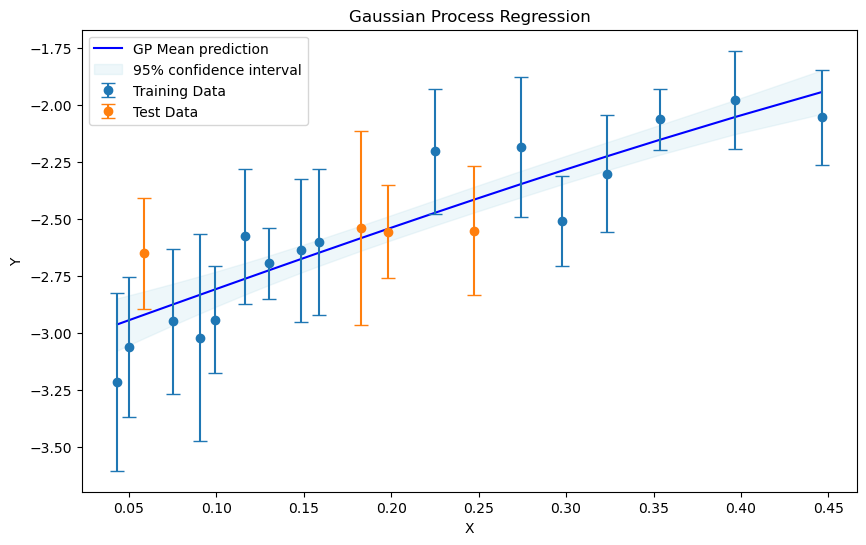

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(x, final_mean, 'b-', label="GP Mean prediction")
plt.errorbar(xtrain.ravel(), ytrain.ravel(), yerr=etrain.ravel(),fmt='o', capsize=5,label = 'Training Data')
plt.errorbar(xtest.ravel(), ytest.ravel(), yerr=etest.ravel(),fmt='o', capsize=5,label = 'Test Data')
plt.fill_between(x.ravel(), final_mean - 2 * final_std, final_mean + 2 * final_std, color="lightblue", alpha=0.2, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()
